# Import Libraries

In [1]:
# Import the libraries
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.sentiment import SentimentIntensityAnalyzer
import emoji
import contractions
from textblob import TextBlob
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data

In [2]:
# Load dataset
df = pd.read_csv("dataset\\sentimentdataset.csv")
print(df.head())

   Unnamed: 0.1  Unnamed: 0  \
0             0           0   
1             1           1   
2             2           2   
3             3           3   
4             4           4   

                                                Text    Sentiment  \
0   Enjoying a beautiful day at the park!        ...   Positive     
1   Traffic was terrible this morning.           ...   Negative     
2   Just finished an amazing workout! 💪          ...   Positive     
3   Excited about the upcoming weekend getaway!  ...   Positive     
4   Trying out a new recipe for dinner tonight.  ...   Neutral      

             Timestamp            User     Platform  \
0  2023-01-15 12:30:00   User123          Twitter     
1  2023-01-15 08:45:00   CommuterX        Twitter     
2  2023-01-15 15:45:00   FitnessFan      Instagram    
3  2023-01-15 18:20:00   AdventureX       Facebook    
4  2023-01-15 19:55:00   ChefCook        Instagram    

                                     Hashtags  Retweets  Likes     

In [3]:
# Analyze the Sentiment column
df['Sentiment'].unique()

array([' Positive  ', ' Negative  ', ' Neutral   ', ' Anger        ',
       ' Fear         ', ' Sadness      ', ' Disgust      ',
       ' Happiness    ', ' Joy          ', ' Love         ',
       ' Amusement    ', ' Enjoyment    ', ' Admiration   ',
       ' Affection    ', ' Awe          ', ' Disappointed ',
       ' Surprise     ', ' Acceptance   ', ' Adoration    ',
       ' Anticipation ', ' Bitter       ', ' Calmness     ',
       ' Confusion    ', ' Excitement   ', ' Kind         ',
       ' Pride        ', ' Shame        ', ' Confusion ', ' Excitement ',
       ' Shame ', ' Elation       ', ' Euphoria      ', ' Contentment   ',
       ' Serenity      ', ' Gratitude     ', ' Hope          ',
       ' Empowerment   ', ' Compassion    ', ' Tenderness    ',
       ' Arousal       ', ' Enthusiasm    ', ' Fulfillment  ',
       ' Reverence     ', ' Compassion', ' Fulfillment   ', ' Reverence ',
       ' Elation   ', ' Despair         ', ' Grief           ',
       ' Loneliness     

In [4]:
# Strip spaces and convert to lowercase
df['Sentiment'] = df['Sentiment'].astype(str).str.strip().str.lower()

In [5]:
# Download the necessary nltk data
nltk.download('vader_lexicon')

# Initialize VADER
sia = SentimentIntensityAnalyzer()

# Define function to categorize sentiments into Positive, Negative, or Neutral
def categorize_sentiment(text):
    score = sia.polarity_scores(str(text))['compound']
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

# Apply to the dataframe
df['Sentiment'] = df['Sentiment'].apply(categorize_sentiment)

# Display updated Sentiment column
print(df['Sentiment'].value_counts())

Sentiment
Positive    378
Negative    183
Neutral     171
Name: count, dtype: int64


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Home\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [6]:
# Confirm the updated unique values
df['Sentiment'].unique()

array(['Positive', 'Negative', 'Neutral'], dtype=object)

# Text Preprocessing

In [7]:
# Remove unnecessary columns
df = df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Timestamp'], errors='ignore')

# Display the text column
print(df['Text'].head())

0     Enjoying a beautiful day at the park!        ...
1     Traffic was terrible this morning.           ...
2     Just finished an amazing workout! 💪          ...
3     Excited about the upcoming weekend getaway!  ...
4     Trying out a new recipe for dinner tonight.  ...
Name: Text, dtype: object


### Tokenization (Split text into words)

In [8]:
nltk.download('punkt')

# Define function to tokenize text
def tokenize_text(text):
    return word_tokenize(text.lower())

# Create a new column
df['Tokenized_Text'] = df['Text'].apply(tokenize_text)

# Display the updated column
print(df['Tokenized_Text'].head())

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Home\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


0      [enjoying, a, beautiful, day, at, the, park, !]
1           [traffic, was, terrible, this, morning, .]
2         [just, finished, an, amazing, workout, !, 💪]
3    [excited, about, the, upcoming, weekend, getaw...
4    [trying, out, a, new, recipe, for, dinner, ton...
Name: Tokenized_Text, dtype: object


### Stopword Removal

In [9]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Define function to remove stopwords
def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

# Create a new column
df['No_Stopwords'] = df['Tokenized_Text'].apply(remove_stopwords)

# Display the updated column
print(df['No_Stopwords'].head())

0          [enjoying, beautiful, day, park, !]
1              [traffic, terrible, morning, .]
2           [finished, amazing, workout, !, 💪]
3     [excited, upcoming, weekend, getaway, !]
4    [trying, new, recipe, dinner, tonight, .]
Name: No_Stopwords, dtype: object


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Home\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Lemmatization (Reduce words to their base form)

In [10]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

lemmatizer = WordNetLemmatizer()

# Function to get POS tag for better lemmatization
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()  # Get first letter of POS tag
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)  # Default to NOUN if not found

# Lemmatization with POS tagging
def lemmatize_words(tokens):
    return [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokens]

df['Lemmatized_Text'] = df['No_Stopwords'].apply(lemmatize_words)

# Display the updated column
print(df['Lemmatized_Text'].head())

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Home\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Home\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


0           [enjoy, beautiful, day, park, !]
1            [traffic, terrible, morning, .]
2             [finish, amaze, workout, !, 💪]
3    [excite, upcoming, weekend, getaway, !]
4     [try, new, recipe, dinner, tonight, .]
Name: Lemmatized_Text, dtype: object


### Handle Noisy Content (Remove emojis, abbreviations, slang, and punctuations)

In [11]:
# Define function to clean noisy content
def clean_noisy_text(tokens):
    cleaned_tokens = []
    
    for word in tokens:
        word = emoji.replace_emoji(word, replace="")  # Remove emojis
        word = contractions.fix(word)  # Expand contractions
        word = str(TextBlob(word).correct())  # Correct slang/abbreviations
        
        if word not in string.punctuation:  # Remove punctuation
            cleaned_tokens.append(word)
    
    return [word for word in cleaned_tokens if word]  # Remove empty words

# Apply the function to the 'Lemmatized_Text' column
df['Cleaned_Text'] = df['Lemmatized_Text'].apply(clean_noisy_text)

# Display the updated column
print(df[['Lemmatized_Text', 'Cleaned_Text']].head())

                           Lemmatized_Text  \
0         [enjoy, beautiful, day, park, !]   
1          [traffic, terrible, morning, .]   
2           [finish, amaze, workout, !, 💪]   
3  [excite, upcoming, weekend, getaway, !]   
4   [try, new, recipe, dinner, tonight, .]   

                          Cleaned_Text  
0        [enjoy, beautiful, day, park]  
1         [traffic, terrible, morning]  
2            [finish, amazed, lookout]  
3   [excite, coming, weekend, gateway]  
4  [try, new, recipe, dinner, tonight]  


In [12]:
# Save the cleaned dataset
df.to_csv("dataset\\cleaned_dataset.csv", index=False)

print("Preprocessing complete. Saved as 'cleaned_dataset.csv'.")

Preprocessing complete. Saved as 'cleaned_dataset.csv'.


# Feature Extraction

In [13]:
# Function for Bag of Words (BoW) feature extraction
def extract_bow_features(text_data):
    """
    Converts text data into a Bag of Words (BoW) representation.
    Returns: BoW feature matrix (DataFrame)
    """
    vectorizer = CountVectorizer()
    bow_matrix = vectorizer.fit_transform(text_data)
    bow_df = pd.DataFrame(bow_matrix.toarray(), columns=vectorizer.get_feature_names_out())
    return bow_df

# Function for TF-IDF feature extraction
def extract_tfidf_features(text_data):
    """
    Converts text data into TF-IDF representation.
    Returns: TF-IDF feature matrix (DataFrame)
    """
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(text_data)
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
    return tfidf_df

# Convert tokenized lists back to text
df['Processed_Text'] = df['Cleaned_Text'].apply(lambda x: ' '.join(x))

# Apply BoW & TF-IDF using functions
bow_df = extract_bow_features(df['Processed_Text'])
tfidf_df = extract_tfidf_features(df['Processed_Text'])

# Display the results
print(bow_df.head())
print(tfidf_df.head())

   ablaze  abstract  abyss  academic  acceptance  accepts  accidentally  \
0       0         0      0         0           0        0             0   
1       0         0      0         0           0        0             0   
2       0         0      0         0           0        0             0   
3       0         0      0         0           0        0             0   
4       0         0      0         0           0        0             0   

   accomplish  accomplishment  ache  ...  wrong  year  yearbook  years  yet  \
0           0               0     0  ...      0     0         0      0    0   
1           0               0     0  ...      0     0         0      0    0   
2           0               0     0  ...      0     0         0      0    0   
3           0               0     0  ...      0     0         0      0    0   
4           0               0     0  ...      0     0         0      0    0   

   york  young  zen  zero  zest  
0     0      0    0     0     0  
1     

# Model Training

### Prepare Data for Training

In [14]:
# Encode sentiment labels (Convert categorical labels into numeric)
label_encoder = LabelEncoder()
df['Sentiment_Label'] = label_encoder.fit_transform(df['Sentiment'])  # Convert "Positive", "Negative", "Neutral" → 0, 1, 2

# Display the updated column
print(df['Sentiment_Label'].head())

0    2
1    0
2    2
3    2
4    1
Name: Sentiment_Label, dtype: int32


In [15]:
# Define features and target
X_bow, X_tfidf = bow_df, tfidf_df
y = df['Sentiment_Label']

# Split data into train and test (80-20)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X_bow, y, test_size=0.2, random_state=42)
X_train_tfidf, X_test_tfidf, _, _ = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

### Train Naive Bayes

In [16]:
# Train Naive Bayes on BoW features
nb_bow = MultinomialNB()
nb_bow.fit(X_train_bow, y_train)
y_pred_nb_bow = nb_bow.predict(X_test_bow)

# Train Naive Bayes on TF-IDF features
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_tfidf, y_train)
y_pred_nb_tfidf = nb_tfidf.predict(X_test_tfidf)

### Train SVM

In [17]:
# Train SVM on BoW features
svm_bow = SVC(kernel='linear')
svm_bow.fit(X_train_bow, y_train)
y_pred_svm_bow = svm_bow.predict(X_test_bow)

# Train SVM on TF-IDF features
svm_tfidf = SVC(kernel='linear')
svm_tfidf.fit(X_train_tfidf, y_train)
y_pred_svm_tfidf = svm_tfidf.predict(X_test_tfidf)

# Model Evaluation

In [18]:
# Evaluate Naive Bayes (BoW)
print("Naive Bayes (BoW) Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_nb_bow))
print("Precision:", precision_score(y_test, y_pred_nb_bow, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_nb_bow, average='weighted'))
print("F1-Score:", f1_score(y_test, y_pred_nb_bow, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb_bow))

Naive Bayes (BoW) Performance:
Accuracy: 0.7210884353741497
Precision: 0.7111866969009827
Recall: 0.7210884353741497
F1-Score: 0.7120620064932952

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.86      0.83        42
           1       0.60      0.45      0.51        40
           2       0.72      0.80      0.76        65

    accuracy                           0.72       147
   macro avg       0.71      0.70      0.70       147
weighted avg       0.71      0.72      0.71       147



In [19]:
# Evaluate Naive Bayes (TF-IDF)
print("Naive Bayes (TF-IDF) Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_nb_tfidf))
print("Precision:", precision_score(y_test, y_pred_nb_tfidf, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_nb_tfidf, average='weighted'))
print("F1-Score:", f1_score(y_test, y_pred_nb_tfidf, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb_tfidf))

Naive Bayes (TF-IDF) Performance:
Accuracy: 0.6258503401360545
Precision: 0.7506063294883171
Recall: 0.6258503401360545
F1-Score: 0.5709793532458324

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.48      0.60        42
           1       1.00      0.17      0.30        40
           2       0.57      1.00      0.72        65

    accuracy                           0.63       147
   macro avg       0.79      0.55      0.54       147
weighted avg       0.75      0.63      0.57       147



In [20]:
# Evaluate SVM (BoW)
print("SVM (BoW) Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_svm_bow))
print("Precision:", precision_score(y_test, y_pred_svm_bow, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_svm_bow, average='weighted'))
print("F1-Score:", f1_score(y_test, y_pred_svm_bow, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm_bow))

SVM (BoW) Performance:
Accuracy: 0.7210884353741497
Precision: 0.7212416498130784
Recall: 0.7210884353741497
F1-Score: 0.7155390989025708

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.74      0.78        42
           1       0.62      0.50      0.56        40
           2       0.71      0.85      0.77        65

    accuracy                           0.72       147
   macro avg       0.72      0.69      0.70       147
weighted avg       0.72      0.72      0.72       147



In [21]:
# Evaluate SVM (TF-IDF)
print("SVM (TF-IDF) Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_svm_tfidf))
print("Precision:", precision_score(y_test, y_pred_svm_tfidf, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_svm_tfidf, average='weighted'))
print("F1-Score:", f1_score(y_test, y_pred_svm_tfidf, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm_tfidf))

SVM (TF-IDF) Performance:
Accuracy: 0.7482993197278912
Precision: 0.794692705457469
Recall: 0.7482993197278912
F1-Score: 0.7305695235966775

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.76      0.80        42
           1       0.94      0.40      0.56        40
           2       0.67      0.95      0.79        65

    accuracy                           0.75       147
   macro avg       0.82      0.71      0.72       147
weighted avg       0.79      0.75      0.73       147



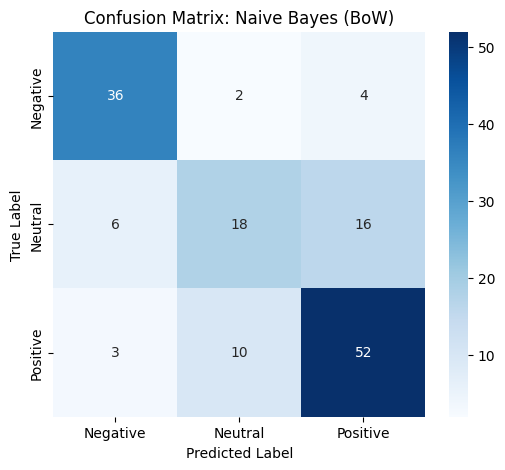

In [22]:
# Confusion Matrix for Naive Bayes (BoW)
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_nb_bow), annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix: Naive Bayes (BoW)")
plt.show()

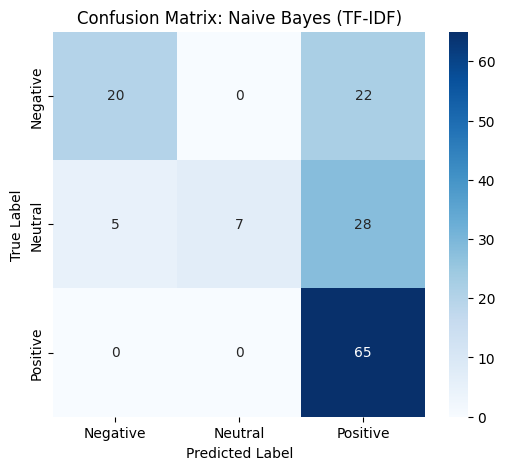

In [23]:
# Confusion Matrix for Naive Bayes (TF-IDF)
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_nb_tfidf), annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix: Naive Bayes (TF-IDF)")
plt.show()

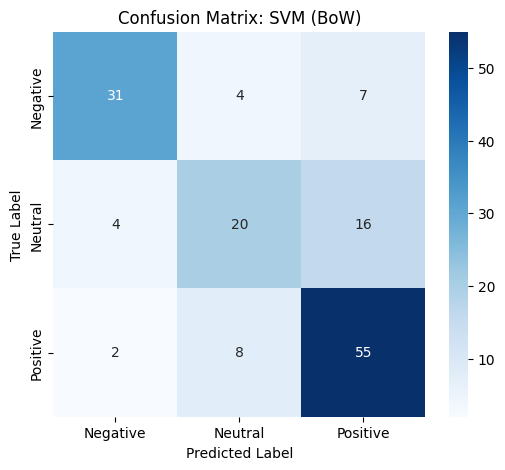

In [24]:
# Confusion Matrix for SVM (BoW)
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_svm_bow), annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix: SVM (BoW)")
plt.show()

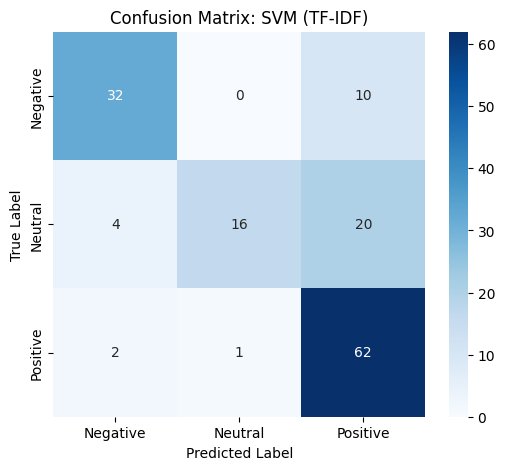

In [25]:
# Confusion Matrix for SVM (TF-IDF)
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_svm_tfidf), annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix: SVM (TF-IDF)")
plt.show()